In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [61]:
df=pd.read_csv('data.csv',delimiter=',', encoding='ISO-8859-1')
lignes_nulles = df[df.isnull().any(axis=1)]
lignes_nulles.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [62]:
df=df.dropna() # enlever les valeurs nulles
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate']) # transformation de la colonne date
df['Description']=df['Description'].str.upper() # on passe les descriptions en masjuscule

In [63]:
# On remplace chaque déscription par le nom le plus fréquent
Description_frequente=df.groupby('StockCode')['Description'].apply(lambda x : x.mode().iloc[0]).reset_index()
# on récupere un vecteur stockcode description sans doublants
Description_frequente=Description_frequente[~Description_frequente['Description'].duplicated(keep=False)]


In [69]:
# modifier les descriptions dans le df
stockcode_description_mapping = Description_frequente.set_index('StockCode')['Description'].to_dict()
df['Description'] = df['StockCode'].map(stockcode_description_mapping)

In [70]:
# on enleve les stockcode qui ne correspondent pas a des articles (bank charges ...)
df=df[~df['StockCode'].str.match(r'^[A-Za-z]')]

In [71]:
# trouver les 3 pays avec le plus d'achats ainsi que les 3 produits les plus achetés par pays 
top_products_by_country = df.groupby(['Country', 'Description']).size().reset_index(name='NombreAchats')
top_products_by_country = top_products_by_country.sort_values(['NombreAchats'], ascending=[False])
top_3_products_by_country = top_products_by_country.groupby('Country').apply(lambda x: x.head(3))
sorted_df=top_3_products_by_country.sort_values(['NombreAchats'], ascending=False)
pd.unique(sorted_df['Country'])[0:3]

array(['United Kingdom', 'Germany', 'France'], dtype=object)

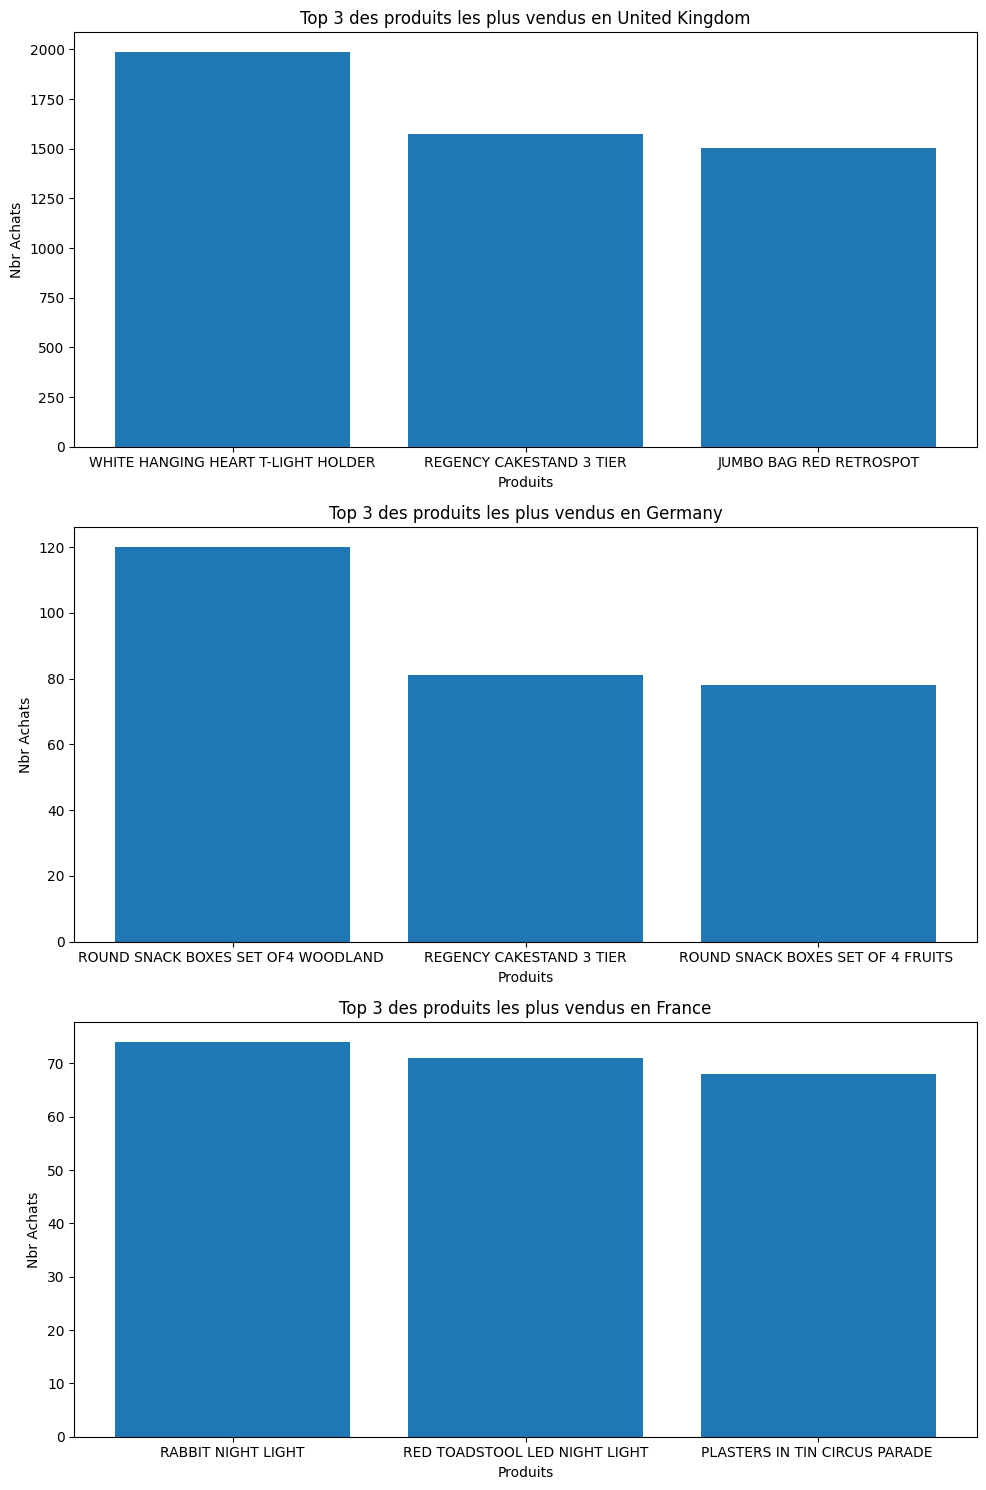

In [72]:
fig, ax = plt.subplots(3, figsize=(10, 15))  # Adjust the figure size as needed

unique_countries = pd.unique(sorted_df['Country'])[0:3]

for i, country in enumerate(unique_countries):
    country_data = sorted_df[sorted_df['Country'] == country]
    ax[i].bar(country_data['Description'], country_data['NombreAchats'])
    ax[i].set_title(f'Top 3 des produits les plus vendus en {country}')
    ax[i].set(xlabel='Produits', ylabel='Nbr Achats')

plt.tight_layout()
plt.show()

Analyse temporelle

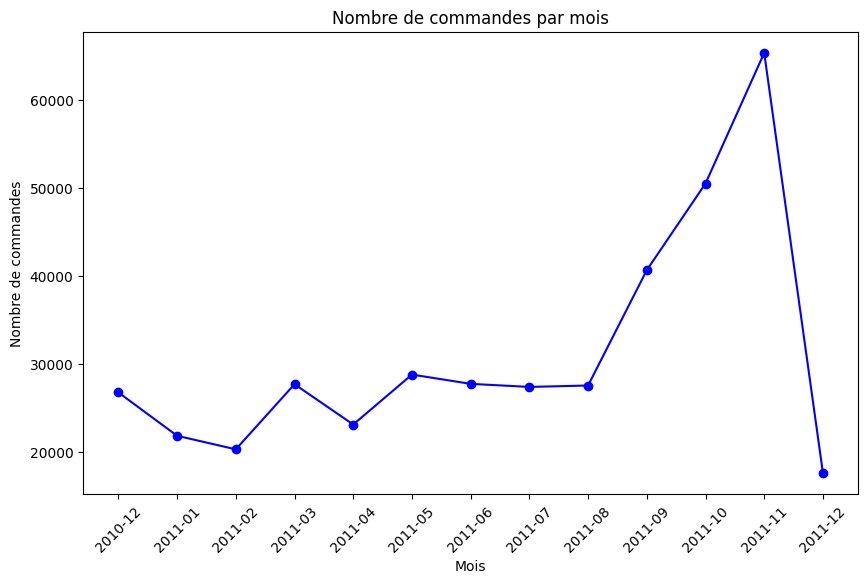

In [73]:
df_grouped = df.groupby(df['InvoiceDate'].dt.to_period("M")).size().reset_index(name='nombre_de_commandes')

# Convertir les objets de type 'Period' en chaînes
df_grouped['InvoiceDate'] = df_grouped['InvoiceDate'].astype(str)

# Tracer le graphique
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['InvoiceDate'], df_grouped['nombre_de_commandes'], marker='o', linestyle='-', color='b')
plt.title('Nombre de commandes par mois')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.show()

Detection de patterns fréquents

In [74]:
# on genre la matrice invoice products
MIP=df.pivot_table(index='InvoiceNo', columns='Description',values='Quantity',aggfunc='sum', fill_value=0)
# on passe la matrice en binaire
MIP_binary=MIP.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\etulyon1\AppData\Local\Temp\ipykernel_10320\724134776.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MIP_binary=MIP.applymap(lambda x: 1 if x > 0 else 0)


In [20]:
# recherche des produits fréquent en allant jusqu'aux combinaison de 3 produits
supports=apriori(MIP_binary,min_support=0.01,max_len=2,use_colnames=True)
supports.sort_values(by="support",ascending=False)

C:\Users\etulyon1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
489,0.090813,(WHITE HANGING HEART T-LIGHT HOLDER)
349,0.078233,(REGENCY CAKESTAND 3 TIER)
204,0.073459,(JUMBO BAG RED RETROSPOT)
286,0.063358,(PARTY BUNTING)
30,0.063128,(ASSORTED COLOUR BIRD ORNAMENT)
...,...,...
480,0.010055,(VINTAGE DONKEY TAIL GAME )
425,0.010055,(SET/2 RED RETROSPOT TEA TOWELS )
719,0.010009,"(SET OF 3 CAKE TINS PANTRY DESIGN , REGENCY CA..."
574,0.010009,"(HOT WATER BOTTLE KEEP CALM, LOVE HOT WATER BO..."


In [21]:
# on s'interesse aux ensemble de 2 produits
pd.set_option("display.max_colwidth", None)
# compter la taille des ensembles
supports["len"] = supports["itemsets"].apply(lambda x: len(x))
# affichage des top 20, ensembles de 2 produits les plus fréquents
G2items=supports[supports["len"]==2].sort_values(by="support", ascending=False)

In [22]:
# on calcule les regles d'association
rules = association_rules(supports, min_threshold=0.05)
# on ordonne selon la metric confidence
rules=rules.sort_values(by="confidence", ascending=False)

In [23]:
patterns=pd.DataFrame({"antecedents" : rules["antecedents"],"consequents" :rules["consequents"], "confidence" :rules["confidence"]})
patterns=patterns.groupby("antecedents")
patterns.head()

,antecedents,consequents,confidence
403,(REGENCY TEA PLATE GREEN ),(REGENCY TEA PLATE ROSES ),0.848148
416,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.828070
82,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.827338
434,(WOODEN TREE CHRISTMAS SCANDINAVIAN),(WOODEN STAR CHRISTMAS SCANDINAVIAN),0.818841
384,(POPPY'S PLAYHOUSE BEDROOM ),(POPPY'S PLAYHOUSE KITCHEN),0.803797
...,...,...,...
44,(WHITE HANGING HEART T-LIGHT HOLDER),(CANDLEHOLDER PINK HANGING HEART),0.152679
98,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER LARGE),0.147118
399,(REGENCY CAKESTAND 3 TIER),(SET OF 3 REGENCY CAKE TINS),0.146714
368,(WHITE HANGING HEART T-LIGHT HOLDER),(PARTY BUNTING),0.141052


In [33]:
# trouver les meilleurs antecedents pour une consequece donnée en se basant sur la metric confidence
consequents=rules[rules["consequents"]=={"GREEN REGENCY TEACUP AND SAUCER"}].sort_values(by="confidence", ascending=False).head(10)

82      frozenset({'PINK REGENCY TEACUP AND SAUCER'})
87    frozenset({'ROSES REGENCY TEACUP AND SAUCER '})
85            frozenset({'REGENCY CAKESTAND 3 TIER'})
Name: antecedents, dtype: object

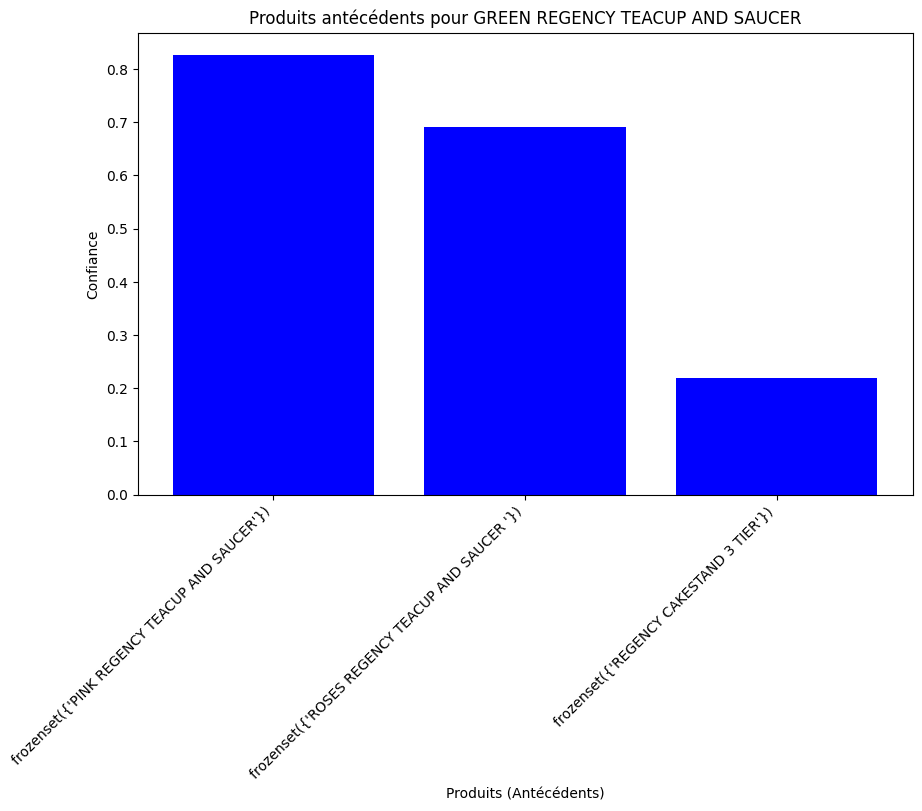

In [75]:
plt.figure(figsize=(10, 6))
plt.bar(consequents["antecedents"].astype(str), consequents["confidence"], color='blue')
plt.xlabel('Produits (Antécédents)')
plt.ylabel('Confiance')
plt.title('Produits antécédents pour GREEN REGENCY TEACUP AND SAUCER')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.show()

In [76]:
# trouver les meilleurs consequences pour un antecedent donné en se basant sur la metric confidence
antecedents=rules[rules["antecedents"]=={"WHITE HANGING HEART T-LIGHT HOLDER"}].sort_values(by="confidence", ascending=False).head(10)

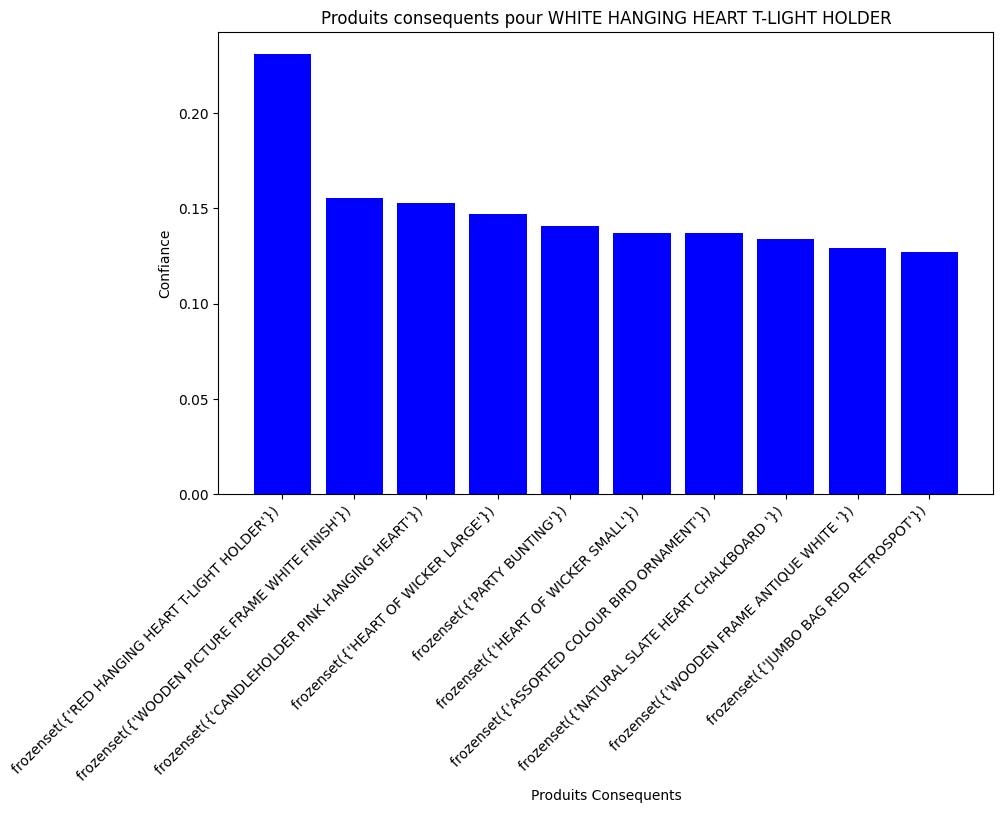

In [77]:
plt.figure(figsize=(10, 6))
plt.bar(antecedents["consequents"].astype(str), antecedents["confidence"], color='blue')
plt.xlabel('Produits Consequents')
plt.ylabel('Confiance')
plt.title('Produits consequents pour WHITE HANGING HEART T-LIGHT HOLDER')
plt.xticks(rotation=45, ha='right')  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
plt.show()